In [2]:
# CELL 1: SETUP, IMPORTS & LOAD CONFIGURATION 

# Install packages (if needed)
!pip install -q torch torchvision scikit-learn pandas matplotlib seaborn

# Core imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                              f1_score, confusion_matrix, classification_report)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import json
import copy
from datetime import datetime
import warnings
import os
import sys
from pathlib import Path
import gc

# Configure warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_style('whitegrid')

print("=" * 80)
print("DAY 4: FULL K-FOLD CROSS-VALIDATION & MODEL OPTIMIZATION")
print("=" * 80)

# Check if running in Google Colab
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    print("\nRunning in Google Colab")
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("\nNot running in Colab - some features may differ")

# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()
print("\nRandom seed set for reproducibility")

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9

    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.2f} GB")

    if 'T4' in gpu_name:
        print(f"Estimated training time: 3-4 hours")
    elif 'P100' in gpu_name:
        print(f"Estimated training time: 2-3 hours")
    elif 'K80' in gpu_name:
        print(f"Estimated training time: 6-8 hours")
    else:
        print(f"Estimated training time: 3-5 hours")
else:
    print("WARNING: No GPU detected!")
    print("Go to: Runtime -> Change runtime type -> Hardware accelerator -> GPU")
    print("Training without GPU will be extremely slow")

# Display package versions
print(f"\nKey Package Versions:")
print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"NumPy: {np.__version__}")

# Create directory structure
directories = ['models', 'outputs', 'visualizations', 'logs']
for dir_name in directories:
    Path(dir_name).mkdir(exist_ok=True)
print(f"\nCreated directories: {', '.join(directories)}")

# Memory clearing function
def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()

print("\nMemory clearing function defined")

# LOAD CONFIGURATIONS
print(f"\n{'=' * 80}")
print("LOADING CONFIGURATIONS")
print("=" * 80)

# Try to load existing configs
try:
    with open('outputs/preprocessing_config.json', 'r') as f:
        preprocessing_config = json.load(f)
    print("Loaded preprocessing_config.json")
except FileNotFoundError:
    print("preprocessing_config.json not found, using defaults")
    preprocessing_config = {
        'image_size': [224, 224],
        'normalize': True,
        'mean': [0.485, 0.456, 0.406],
        'std': [0.229, 0.224, 0.225]
    }
    # Save default config
    with open('outputs/preprocessing_config.json', 'w') as f:
        json.dump(preprocessing_config, f, indent=2)
    print("Created default preprocessing_config.json")

# Try to load class weights
class_weights = None
try:
    with open('outputs/class_weights.json', 'r') as f:
        weights_data = json.load(f)
    class_weights = weights_data.get('class_weights', None)
    if class_weights:
        print(f"Loaded class_weights.json")
    else:
        print("No class weights found in file")
except FileNotFoundError:
    print("class_weights.json not found, will calculate from data")

# Best Configuration from hyperparameter search
best_config = {
    'model_name': 'resnet50',
    'learning_rate': 0.001,
    'batch_size': 32,
    'optimizer': 'adam',
    'dropout_rate': 0.5,
    'unfreeze_layers': 0,
    'epochs': 20,
    'patience': 5,
    'class_weights': class_weights
}

print(f"\nUsing Optimized Configuration:")
for key, val in best_config.items():
    print(f"{key:20} {val}")

# Save configuration for reproducibility
with open('outputs/day4_config.json', 'w') as f:
    json.dump(best_config, f, indent=2)
print(f"\nConfiguration saved to: outputs/day4_config.json")

print(f"\n{'=' * 80}")
print(f"Setup complete! Ready for Day 4.")
print(f"{'=' * 80}\n")

You should consider upgrading via the '/Users/neerajkumar/Downloads/MediScan-AI/mediscan_env/bin/python3 -m pip install --upgrade pip' command.
DAY 4: FULL K-FOLD CROSS-VALIDATION & MODEL OPTIMIZATION

Not running in Colab - some features may differ

Random seed set for reproducibility

Device: cpu
Go to: Runtime -> Change runtime type -> Hardware accelerator -> GPU
Training without GPU will be extremely slow

Key Package Versions:
PyTorch: 2.8.0
Torchvision: 0.23.0
NumPy: 2.0.2

Created directories: models, outputs, visualizations, logs

Memory clearing function defined

LOADING CONFIGURATIONS
Loaded preprocessing_config.json
class_weights.json not found, will calculate from data

Using Optimized Configuration:
model_name           resnet50
learning_rate        0.001
batch_size           32
optimizer            adam
dropout_rate         0.5
unfreeze_layers      0
epochs               20
patience             5
class_weights        None

Configuration saved to: outputs/day4_config.json


In [3]:
#================================================================================
# CELL 2: DATA LOADING & K-FOLD PREPARATION 
#================================================================================

print("\n" + "="*80)
print("DATA LOADING & K-FOLD PREPARATION")
print("="*80)

# Set directory paths based on your existing structure
data_dir = Path('../data/chest_xray')
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
val_dir = data_dir / 'val'

print(f"Dataset structure:")
print(f"   Training directory: {train_dir}")
print(f"   Testing directory:  {test_dir}")
print(f"   Validation directory: {val_dir}")

# Verify the dataset structure
print(f"\nVerifying dataset structure...")

def check_directory_structure(path, name):
    if path.exists():
        subdirs = [f for f in path.iterdir() if f.is_dir()]
        print(f"   {name}: Found {len(subdirs)} classes - {[d.name for d in subdirs]}")

        # Count samples in each class
        for subdir in subdirs:
            samples = len(list(subdir.glob('*.jpeg'))) + len(list(subdir.glob('*.jpg'))) + len(list(subdir.glob('*.png')))
            print(f"      {subdir.name}: {samples} images")
        return True
    else:
        print(f"   {name}: Directory not found")
        return False

# Check all directories
train_ok = check_directory_structure(train_dir, "Training")
test_ok = check_directory_structure(test_dir, "Testing")
val_ok = check_directory_structure(val_dir, "Validation")

if not train_ok or not test_ok:
    raise FileNotFoundError("Essential dataset directories (train/test) not found!")

# Enhanced data transforms (optimized for medical X-ray images)
print(f"\nCreating data transforms...")

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print(f"Transforms created")
print(f"   Training: Resize(256) -> RandomCrop(224) -> Flip -> Rotate -> Affine")
print(f"   Testing:  Resize(224) -> No augmentation")

# Load datasets
print(f"\nLoading datasets...")
train_dataset = ImageFolder(root=str(train_dir), transform=train_transform)
test_dataset = ImageFolder(root=str(test_dir), transform=test_transform)

# Dataset info
class_names = train_dataset.classes
num_classes = len(class_names)

# Extract labels
print(f"\nExtracting labels...")
all_labels = [train_dataset.targets[i] for i in range(len(train_dataset))]

print(f"\nDatasets loaded successfully!")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Test samples:     {len(test_dataset)}")
print(f"   Classes ({num_classes}): {class_names}")

# Class distribution
unique, counts = np.unique(all_labels, return_counts=True)
print(f"\nTraining Set Class Distribution:")
for cls, count in zip(class_names, counts):
    percentage = 100 * count / len(all_labels)
    print(f"   {cls:15} {count:5} samples ({percentage:5.1f}%)")

# Calculate imbalance ratio
imbalance_ratio = max(counts) / min(counts)
print(f"\n   Imbalance ratio: {imbalance_ratio:.2f}:1", end="")
if imbalance_ratio > 2:
    print(f" (Class weights recommended)")
else:
    print(f" (Relatively balanced)")

# Calculate class weights
print(f"\nCalculating class weights...")
total = len(all_labels)
class_weights = [total / (num_classes * count) for count in counts]

print(f"   Calculated weights:")
for cls, weight in zip(class_names, class_weights):
    print(f"   {cls:15} {weight:.4f}")

# Save for reference
Path('outputs').mkdir(exist_ok=True)
with open('outputs/class_weights.json', 'w') as f:
    json.dump({
        'class_weights': class_weights,
        'class_names': class_names,
        'class_counts': counts.tolist()
    }, f, indent=2)
print(f"   Saved to: outputs/class_weights.json")

# Update config with class weights
best_config['class_weights'] = class_weights

# Initialize StratifiedKFold
print(f"\nCreating K-Fold splits...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
splits = list(skf.split(np.zeros(len(all_labels)), all_labels))

print(f"K-Fold splits created:")
print(f"   Number of folds: 5")
print(f"   Random state: 42 (reproducible)")
print(f"   Stratified: Yes (maintains class distribution)")

# Verify stratification
print(f"\nVerifying Fold Stratification:")
print(f"{'Fold':<6} {'Size':<8} {class_names[0]:<12} {class_names[1]:<12} {'Ratio':<8}")
print(f"{'-'*60}")

for fold_num, (train_idx, val_idx) in enumerate(splits, 1):
    val_labels_fold = [all_labels[i] for i in val_idx]
    val_counts_fold = np.bincount(val_labels_fold)
    ratio = val_counts_fold[1] / val_counts_fold[0] if val_counts_fold[0] > 0 else 0

    print(f"  {fold_num:<6} {len(val_idx):<8} {val_counts_fold[0]:<12} "
          f"{val_counts_fold[1]:<12} {ratio:<8.2f}")

print(f"{'-'*60}")

# Calculate overall class distribution
overall_ratio = counts[1] / counts[0] if counts[0] > 0 else 0
print(f"Overall {len(all_labels):<8} {counts[0]:<12} {counts[1]:<12} {overall_ratio:<8.2f}")
print(f"\nStratification verified - all folds maintain class distribution!")

# Save dataset info
dataset_info = {
    'train_samples': len(train_dataset),
    'test_samples': len(test_dataset),
    'num_classes': num_classes,
    'class_names': class_names,
    'class_counts': counts.tolist(),
    'class_weights': class_weights,
    'train_dir': str(train_dir),
    'test_dir': str(test_dir),
    'imbalance_ratio': float(imbalance_ratio),
    'fold_info': {
        'n_splits': 5,
        'random_state': 42,
        'stratified': True
    }
}

with open('outputs/dataset_info.json', 'w') as f:
    json.dump(dataset_info, f, indent=2)

print(f"\n{'='*80}")
print(f"Data preparation complete!")
print(f"{'='*80}")
print(f"Dataset info saved to: outputs/dataset_info.json")
print(f"Ready to proceed with model training!\n")


DATA LOADING & K-FOLD PREPARATION
Dataset structure:
   Training directory: ../data/chest_xray/train
   Testing directory:  ../data/chest_xray/test
   Validation directory: ../data/chest_xray/val

Verifying dataset structure...
   Training: Found 2 classes - ['PNEUMONIA', 'NORMAL']
      PNEUMONIA: 3875 images
      NORMAL: 1341 images
   Testing: Found 2 classes - ['PNEUMONIA', 'NORMAL']
      PNEUMONIA: 390 images
      NORMAL: 234 images
   Validation: Found 2 classes - ['PNEUMONIA', 'NORMAL']
      PNEUMONIA: 8 images
      NORMAL: 8 images

Creating data transforms...
Transforms created
   Training: Resize(256) -> RandomCrop(224) -> Flip -> Rotate -> Affine
   Testing:  Resize(224) -> No augmentation

Loading datasets...

Extracting labels...

Datasets loaded successfully!
   Training samples: 5216
   Test samples:     624
   Classes (2): ['NORMAL', 'PNEUMONIA']

Training Set Class Distribution:
   NORMAL           1341 samples ( 25.7%)
   PNEUMONIA        3875 samples ( 74.3%)



In [4]:
#================================================================================
# CELL 3: MODEL BUILDER & TRAINING PIPELINE
#================================================================================
"""
What this does: Define model architecture and training functions
"""

print("\n" + "="*80)
print("MODEL BUILDER & TRAINING PIPELINE")
print("="*80)

# ============================================================================
# MODEL BUILDER
# ============================================================================

def build_model(model_name='resnet50', num_classes=2, dropout_rate=0.5,
                unfreeze_layers=0, pretrained=True):
    """
    Build and configure model

    Args:
        model_name: Model architecture (resnet50, resnet18)
        num_classes: Number of output classes
        dropout_rate: Dropout probability
        unfreeze_layers: Number of layers to unfreeze (0 = all frozen)
        pretrained: Use ImageNet pretrained weights

    Returns:
        model: Configured PyTorch model
    """
    print(f"\nBuilding {model_name}...")
    print(f"  Pretrained: {pretrained}")
    print(f"  Dropout: {dropout_rate}")
    print(f"  Unfreeze layers: {unfreeze_layers}")

    # Load base model
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=pretrained)
        num_features = model.fc.in_features

        # Freeze all layers initially
        for param in model.parameters():
            param.requires_grad = False

        # Optionally unfreeze last N layers
        if unfreeze_layers > 0:
            layers = list(model.children())
            for layer in layers[-(unfreeze_layers + 1):-1]:
                for param in layer.parameters():
                    param.requires_grad = True
            print(f"  Unfroze last {unfreeze_layers} layer(s)")

        # Replace classifier head
        model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    elif model_name == 'resnet18':
        model = models.resnet18(pretrained=pretrained)
        num_features = model.fc.in_features

        for param in model.parameters():
            param.requires_grad = False

        if unfreeze_layers > 0:
            layers = list(model.children())
            for layer in layers[-(unfreeze_layers + 1):-1]:
                for param in layer.parameters():
                    param.requires_grad = True

        model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, num_classes)
        )

    else:
        raise ValueError(f"Unknown model: {model_name}")

    # Calculate trainable parameters
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"  Trainable params: {trainable:,} / {total:,} ({100*trainable/total:.1f}%)")

    return model.to(device)

# ============================================================================
# TRAINING FUNCTION FOR SINGLE FOLD
# ============================================================================

def train_single_fold(fold_num, train_idx, val_idx, config, dataset):
    """
    Train model on a single fold

    Args:
        fold_num: Fold number (1-5)
        train_idx: Training sample indices
        val_idx: Validation sample indices
        config: Training configuration dict
        dataset: Full dataset

    Returns:
        results: Dictionary with metrics and history
    """

    print(f"\n{'='*80}")
    print(f"TRAINING FOLD {fold_num}/5")
    print(f"{'='*80}")
    print(f"Train samples: {len(train_idx)}")
    print(f"Val samples: {len(val_idx)}")

    # Create data loaders
    train_loader = DataLoader(
        dataset,
        batch_size=config['batch_size'],
        sampler=SubsetRandomSampler(train_idx),
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        dataset,
        batch_size=config['batch_size'],
        sampler=SubsetRandomSampler(val_idx),
        num_workers=2,
        pin_memory=True
    )

    # Build model
    model = build_model(
        model_name=config['model_name'],
        num_classes=num_classes,
        dropout_rate=config['dropout_rate'],
        unfreeze_layers=config.get('unfreeze_layers', 0)
    )

    # Setup optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    elif config['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=0.01)
    else:
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

    # Setup loss function with class weights
    if config['class_weights'] is not None:
        weights = torch.FloatTensor(config['class_weights']).to(device)
        criterion = nn.CrossEntropyLoss(weight=weights)
        print(f"\nUsing class weights: {config['class_weights']}")
    else:
        criterion = nn.CrossEntropyLoss()
        print(f"\nNo class weights applied")

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2
    )

    # Training tracking
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': []
    }

    best_val_acc = 0.0
    best_epoch = 0
    best_model_wts = None
    patience_counter = 0

    # Training loop
    print(f"\nStarting training for {config['epochs']} epochs...")
    print(f"Early stopping patience: {config['patience']}")

    for epoch in range(config['epochs']):
        # TRAINING PHASE
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["epochs"]} [TRAIN]', leave=False)
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

            train_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        epoch_train_loss = train_loss / len(train_idx)
        epoch_train_acc = accuracy_score(train_labels, train_preds)

        # VALIDATION PHASE
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{config["epochs"]} [VAL]  ', leave=False)
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

                val_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        epoch_val_loss = val_loss / len(val_idx)
        epoch_val_acc = accuracy_score(val_labels, val_preds)
        epoch_val_precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
        epoch_val_recall = recall_score(val_labels, val_preds, average='weighted', zero_division=0)
        epoch_val_f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)

        # Update history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['val_precision'].append(epoch_val_precision)
        history['val_recall'].append(epoch_val_recall)
        history['val_f1'].append(epoch_val_f1)

        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{config['epochs']}:")
        print(f"  Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f}")
        print(f"  Val   Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")
        print(f"  Val   Prec: {epoch_val_precision:.4f}, Rec: {epoch_val_recall:.4f}, F1: {epoch_val_f1:.4f}")

        # Learning rate scheduling
        scheduler.step(epoch_val_acc)

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print(f"  >> New best model! Val Acc: {best_val_acc:.4f}")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= config['patience']:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            print(f"No improvement for {config['patience']} epochs")
            break

    # Load best weights
    model.load_state_dict(best_model_wts)

    # Final evaluation on validation set
    model.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculate final metrics
    final_acc = accuracy_score(val_labels, val_preds)
    final_prec = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    final_rec = recall_score(val_labels, val_preds, average='weighted', zero_division=0)
    final_f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)
    final_cm = confusion_matrix(val_labels, val_preds)

    # Per-class metrics
    class_report = classification_report(val_labels, val_preds,
                                        target_names=class_names,
                                        output_dict=True)

    # Save model checkpoint
    checkpoint_path = f'models/resnet50_fold_{fold_num}_best.pth'
    torch.save({
        'fold': fold_num,
        'epoch': best_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_acc': best_val_acc,
        'config': config
    }, checkpoint_path)

    print(f"\nFold {fold_num} Training Complete!")
    print(f"  Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch+1})")
    print(f"  Final Metrics:")
    print(f"    Accuracy:  {final_acc:.4f}")
    print(f"    Precision: {final_prec:.4f}")
    print(f"    Recall:    {final_rec:.4f}")
    print(f"    F1-Score:  {final_f1:.4f}")
    print(f"  Model saved: {checkpoint_path}")

    # Prepare results
    results = {
        'fold': fold_num,
        'best_epoch': best_epoch,
        'best_val_acc': best_val_acc,
        'accuracy': final_acc,
        'precision': final_prec,
        'recall': final_rec,
        'f1_score': final_f1,
        'confusion_matrix': final_cm.tolist(),
        'classification_report': class_report,
        'history': history,
        'checkpoint_path': checkpoint_path
    }

    # Save fold results
    with open(f'outputs/fold_{fold_num}_results.json', 'w') as f:
        json.dump({
            'fold': fold_num,
            'best_epoch': best_epoch,
            'best_val_acc': best_val_acc,
            'accuracy': final_acc,
            'precision': final_prec,
            'recall': final_rec,
            'f1_score': final_f1
        }, f, indent=2)

    # Clean up memory
    del model, optimizer, train_loader, val_loader
    torch.cuda.empty_cache()
    gc.collect()

    return results

# ============================================================================
# AUTOMATED TRAINING FOR ALL FOLDS
# ============================================================================

def train_all_folds(config, dataset, splits):
    """
    Train models on all 5 folds with resume capability

    Args:
        config: Training configuration
        dataset: Full dataset
        splits: List of (train_idx, val_idx) tuples

    Returns:
        all_results: List of results for each fold
    """

    print(f"\n{'#'*80}")
    print(f"STARTING 5-FOLD CROSS-VALIDATION TRAINING")
    print(f"{'#'*80}")
    print(f"\nEstimated time: 3-4 hours")
    print(f"This is automated - perfect time for a break!\n")

    start_time = datetime.now()
    all_results = []

    # Check for existing results
    completed_folds = []
    for fold_num in range(1, 6):
        if os.path.exists(f'outputs/fold_{fold_num}_results.json'):
            try:
                with open(f'outputs/fold_{fold_num}_results.json', 'r') as f:
                    fold_data = json.load(f)
                    completed_folds.append(fold_num)
                    all_results.append(fold_data)
            except:
                pass

    if completed_folds:
        print(f"Found existing results for folds: {completed_folds}")
        resume_from = max(completed_folds) + 1 if max(completed_folds) < 5 else 6
        print(f"Resuming from fold {resume_from}\n")
    else:
        resume_from = 1

    # Train each fold
    for fold_num, (train_idx, val_idx) in enumerate(splits, 1):
        # Skip if already completed
        if fold_num in completed_folds:
            print(f"\nSkipping fold {fold_num} (already completed)")
            continue

        fold_start = datetime.now()

        try:
            fold_results = train_single_fold(
                fold_num=fold_num,
                train_idx=train_idx,
                val_idx=val_idx,
                config=config,
                dataset=dataset
            )

            all_results.append(fold_results)

            fold_time = (datetime.now() - fold_start).total_seconds() / 60
            print(f"\nFold {fold_num} completed in {fold_time:.1f} minutes")

        except Exception as e:
            print(f"\nERROR in Fold {fold_num}: {str(e)}")
            import traceback
            traceback.print_exc()

            # Save partial results
            if all_results:
                with open('outputs/partial_results.json', 'w') as f:
                    json.dump({
                        'completed_folds': [r['fold'] for r in all_results],
                        'failed_fold': fold_num,
                        'error': str(e)
                    }, f, indent=2)
            continue

    total_time = (datetime.now() - start_time).total_seconds() / 60

    print(f"\n{'#'*80}")
    print(f"ALL FOLDS TRAINING COMPLETE!")
    print(f"{'#'*80}")
    print(f"Total time: {total_time:.1f} minutes ({total_time/60:.1f} hours)")
    print(f"Completed folds: {len(all_results)}/5")

    # Save complete results
    with open('outputs/all_folds_results.json', 'w') as f:
        json.dump({
            'config': config,
            'all_results': all_results,
            'total_time_minutes': total_time,
            'completion_time': datetime.now().isoformat()
        }, f, indent=2)

    return all_results

print("\nTraining pipeline functions defined!")
print("Ready to train all folds.\n")



MODEL BUILDER & TRAINING PIPELINE

Training pipeline functions defined!
Ready to train all folds.



In [5]:
#================================================================================
# CELL 4: TRAIN ALL 5 FOLDS
#================================================================================
"""
What this does: Runs automated training on all 5 folds
LONG RUN - Perfect time for lunch/break!

This cell will:
- Train 5 independent models (one per fold)
- Save checkpoints automatically
- Handle errors gracefully
- Resume from previous runs if interrupted
"""

print("\n" + "="*80)
print("EXECUTING FULL 5-FOLD CROSS-VALIDATION")
print("="*80)

# Run the automated training pipeline
all_fold_results = train_all_folds(
    config=best_config,
    dataset=train_dataset,
    splits=splits
)

print(f"\nTraining pipeline execution complete!")
print(f"Results saved to: outputs/all_folds_results.json")
print(f"Model checkpoints: models/resnet50_fold_1_best.pth ... fold_5_best.pth")
print(f"\nNext: Run Cell 5 to aggregate results and visualize\n")


EXECUTING FULL 5-FOLD CROSS-VALIDATION

################################################################################
STARTING 5-FOLD CROSS-VALIDATION TRAINING
################################################################################

Estimated time: 3-4 hours
This is automated - perfect time for a break!


TRAINING FOLD 1/5
Train samples: 4172
Val samples: 1044

Building resnet50...
  Pretrained: True
  Dropout: 0.5
  Unfreeze layers: 0
  Trainable params: 1,050,114 / 24,558,146 (4.3%)

Using class weights: [np.float64(1.9448173005219984), np.float64(0.6730322580645162)]

Starting training for 20 epochs...
Early stopping patience: 5


Epoch 1/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 1/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 1/20:
  Train Loss: 0.3880, Acc: 0.8303
  Val   Loss: 0.2413, Acc: 0.9310
  Val   Prec: 0.9302, Rec: 0.9310, F1: 0.9304
  >> New best model! Val Acc: 0.9310


Epoch 2/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 2/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 2/20:
  Train Loss: 0.2799, Acc: 0.8837
  Val   Loss: 0.2320, Acc: 0.8755
  Val   Prec: 0.9124, Rec: 0.8755, F1: 0.8817


Epoch 3/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 3/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 3/20:
  Train Loss: 0.2510, Acc: 0.8962
  Val   Loss: 0.1836, Acc: 0.9215
  Val   Prec: 0.9319, Rec: 0.9215, F1: 0.9237


Epoch 4/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 4/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 4/20:
  Train Loss: 0.2483, Acc: 0.9012
  Val   Loss: 0.1793, Acc: 0.9425
  Val   Prec: 0.9456, Rec: 0.9425, F1: 0.9434
  >> New best model! Val Acc: 0.9425


Epoch 5/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 5/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 5/20:
  Train Loss: 0.2565, Acc: 0.8988
  Val   Loss: 0.1857, Acc: 0.9397
  Val   Prec: 0.9412, Rec: 0.9397, F1: 0.9402


Epoch 6/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 6/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 6/20:
  Train Loss: 0.2271, Acc: 0.9051
  Val   Loss: 0.1668, Acc: 0.9330
  Val   Prec: 0.9366, Rec: 0.9330, F1: 0.9340


Epoch 7/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 7/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 7/20:
  Train Loss: 0.2274, Acc: 0.9068
  Val   Loss: 0.3685, Acc: 0.7835
  Val   Prec: 0.8772, Rec: 0.7835, F1: 0.7970


Epoch 8/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 8/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 8/20:
  Train Loss: 0.2374, Acc: 0.8998
  Val   Loss: 0.1766, Acc: 0.9119
  Val   Prec: 0.9301, Rec: 0.9119, F1: 0.9152


Epoch 9/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 9/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 9/20:
  Train Loss: 0.2090, Acc: 0.9163
  Val   Loss: 0.1730, Acc: 0.9272
  Val   Prec: 0.9353, Rec: 0.9272, F1: 0.9290

Early stopping triggered at epoch 9
No improvement for 5 epochs

Fold 1 Training Complete!
  Best Val Acc: 0.9425 (Epoch 4)
  Final Metrics:
    Accuracy:  0.9368
    Precision: 0.9423
    Recall:    0.9368
    F1-Score:  0.9381
  Model saved: models/resnet50_fold_1_best.pth

Fold 1 completed in 93.4 minutes

TRAINING FOLD 2/5
Train samples: 4173
Val samples: 1043

Building resnet50...
  Pretrained: True
  Dropout: 0.5
  Unfreeze layers: 0
  Trainable params: 1,050,114 / 24,558,146 (4.3%)

Using class weights: [np.float64(1.9448173005219984), np.float64(0.6730322580645162)]

Starting training for 20 epochs...
Early stopping patience: 5


Epoch 1/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 1/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 1/20:
  Train Loss: 0.3615, Acc: 0.8313
  Val   Loss: 0.2488, Acc: 0.9377
  Val   Prec: 0.9379, Rec: 0.9377, F1: 0.9360
  >> New best model! Val Acc: 0.9377


Epoch 2/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 2/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 2/20:
  Train Loss: 0.2837, Acc: 0.8838
  Val   Loss: 0.1602, Acc: 0.9549
  Val   Prec: 0.9558, Rec: 0.9549, F1: 0.9552
  >> New best model! Val Acc: 0.9549


Epoch 3/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 3/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 3/20:
  Train Loss: 0.2846, Acc: 0.8826
  Val   Loss: 0.2126, Acc: 0.9415
  Val   Prec: 0.9409, Rec: 0.9415, F1: 0.9408


Epoch 4/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 4/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 4/20:
  Train Loss: 0.2703, Acc: 0.8886
  Val   Loss: 0.1877, Acc: 0.9521
  Val   Prec: 0.9521, Rec: 0.9521, F1: 0.9521


Epoch 5/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 5/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 5/20:
  Train Loss: 0.2458, Acc: 0.8998
  Val   Loss: 0.1539, Acc: 0.9281
  Val   Prec: 0.9408, Rec: 0.9281, F1: 0.9304


Epoch 6/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 6/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 6/20:
  Train Loss: 0.2332, Acc: 0.9013
  Val   Loss: 0.1387, Acc: 0.9492
  Val   Prec: 0.9529, Rec: 0.9492, F1: 0.9501


Epoch 7/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 7/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 7/20:
  Train Loss: 0.2347, Acc: 0.9034
  Val   Loss: 0.1507, Acc: 0.9367
  Val   Prec: 0.9454, Rec: 0.9367, F1: 0.9384

Early stopping triggered at epoch 7
No improvement for 5 epochs

Fold 2 Training Complete!
  Best Val Acc: 0.9549 (Epoch 2)
  Final Metrics:
    Accuracy:  0.9425
    Precision: 0.9430
    Recall:    0.9425
    F1-Score:  0.9427
  Model saved: models/resnet50_fold_2_best.pth

Fold 2 completed in 72.4 minutes

TRAINING FOLD 3/5
Train samples: 4173
Val samples: 1043

Building resnet50...
  Pretrained: True
  Dropout: 0.5
  Unfreeze layers: 0
  Trainable params: 1,050,114 / 24,558,146 (4.3%)

Using class weights: [np.float64(1.9448173005219984), np.float64(0.6730322580645162)]

Starting training for 20 epochs...
Early stopping patience: 5


Epoch 1/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 1/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 1/20:
  Train Loss: 0.3909, Acc: 0.8368
  Val   Loss: 0.1994, Acc: 0.9271
  Val   Prec: 0.9317, Rec: 0.9271, F1: 0.9284
  >> New best model! Val Acc: 0.9271


Epoch 2/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 2/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 2/20:
  Train Loss: 0.2758, Acc: 0.8857
  Val   Loss: 0.1992, Acc: 0.9195
  Val   Prec: 0.9224, Rec: 0.9195, F1: 0.9205


Epoch 3/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 3/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 3/20:
  Train Loss: 0.2665, Acc: 0.8948
  Val   Loss: 0.2070, Acc: 0.9377
  Val   Prec: 0.9390, Rec: 0.9377, F1: 0.9382
  >> New best model! Val Acc: 0.9377


Epoch 4/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 4/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 4/20:
  Train Loss: 0.2626, Acc: 0.8890
  Val   Loss: 0.1851, Acc: 0.9214
  Val   Prec: 0.9324, Rec: 0.9214, F1: 0.9237


Epoch 5/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 5/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 5/20:
  Train Loss: 0.2367, Acc: 0.9087
  Val   Loss: 0.1976, Acc: 0.8945
  Val   Prec: 0.9220, Rec: 0.8945, F1: 0.8993


Epoch 6/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 6/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 6/20:
  Train Loss: 0.2543, Acc: 0.9001
  Val   Loss: 0.2131, Acc: 0.8917
  Val   Prec: 0.9189, Rec: 0.8917, F1: 0.8965


Epoch 7/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 7/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 7/20:
  Train Loss: 0.2169, Acc: 0.9113
  Val   Loss: 0.1727, Acc: 0.9300
  Val   Prec: 0.9364, Rec: 0.9300, F1: 0.9315


Epoch 8/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 8/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 8/20:
  Train Loss: 0.2162, Acc: 0.9104
  Val   Loss: 0.1634, Acc: 0.9243
  Val   Prec: 0.9328, Rec: 0.9243, F1: 0.9262

Early stopping triggered at epoch 8
No improvement for 5 epochs

Fold 3 Training Complete!
  Best Val Acc: 0.9377 (Epoch 3)
  Final Metrics:
    Accuracy:  0.9262
    Precision: 0.9271
    Recall:    0.9262
    F1-Score:  0.9266
  Model saved: models/resnet50_fold_3_best.pth

Fold 3 completed in 81.2 minutes

TRAINING FOLD 4/5
Train samples: 4173
Val samples: 1043

Building resnet50...
  Pretrained: True
  Dropout: 0.5
  Unfreeze layers: 0
  Trainable params: 1,050,114 / 24,558,146 (4.3%)

Using class weights: [np.float64(1.9448173005219984), np.float64(0.6730322580645162)]

Starting training for 20 epochs...
Early stopping patience: 5


Epoch 1/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 1/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 1/20:
  Train Loss: 0.3631, Acc: 0.8342
  Val   Loss: 0.1620, Acc: 0.9291
  Val   Prec: 0.9414, Rec: 0.9291, F1: 0.9313
  >> New best model! Val Acc: 0.9291


Epoch 2/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 2/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 2/20:
  Train Loss: 0.2767, Acc: 0.8859
  Val   Loss: 0.1766, Acc: 0.9137
  Val   Prec: 0.9306, Rec: 0.9137, F1: 0.9168


Epoch 3/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 3/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 3/20:
  Train Loss: 0.2586, Acc: 0.8960
  Val   Loss: 0.1723, Acc: 0.9099
  Val   Prec: 0.9290, Rec: 0.9099, F1: 0.9133


Epoch 4/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 4/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 4/20:
  Train Loss: 0.2604, Acc: 0.8941
  Val   Loss: 0.2387, Acc: 0.8667
  Val   Prec: 0.9084, Rec: 0.8667, F1: 0.8737


Epoch 5/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 5/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 5/20:
  Train Loss: 0.2316, Acc: 0.9058
  Val   Loss: 0.1512, Acc: 0.9406
  Val   Prec: 0.9477, Rec: 0.9406, F1: 0.9420
  >> New best model! Val Acc: 0.9406


Epoch 6/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 6/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 6/20:
  Train Loss: 0.2282, Acc: 0.9061
  Val   Loss: 0.1644, Acc: 0.9204
  Val   Prec: 0.9329, Rec: 0.9204, F1: 0.9229


Epoch 7/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 7/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 7/20:
  Train Loss: 0.2223, Acc: 0.9051
  Val   Loss: 0.1673, Acc: 0.9453
  Val   Prec: 0.9470, Rec: 0.9453, F1: 0.9459
  >> New best model! Val Acc: 0.9453


Epoch 8/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 8/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 8/20:
  Train Loss: 0.2375, Acc: 0.9061
  Val   Loss: 0.1599, Acc: 0.9415
  Val   Prec: 0.9455, Rec: 0.9415, F1: 0.9425


Epoch 9/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 9/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 9/20:
  Train Loss: 0.2455, Acc: 0.8979
  Val   Loss: 0.1695, Acc: 0.9367
  Val   Prec: 0.9449, Rec: 0.9367, F1: 0.9384


Epoch 10/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 10/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 10/20:
  Train Loss: 0.2283, Acc: 0.9097
  Val   Loss: 0.1588, Acc: 0.9358
  Val   Prec: 0.9419, Rec: 0.9358, F1: 0.9372


Epoch 11/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 11/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 11/20:
  Train Loss: 0.2094, Acc: 0.9168
  Val   Loss: 0.1577, Acc: 0.9386
  Val   Prec: 0.9458, Rec: 0.9386, F1: 0.9401


Epoch 12/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 12/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 12/20:
  Train Loss: 0.2092, Acc: 0.9053
  Val   Loss: 0.1626, Acc: 0.9338
  Val   Prec: 0.9401, Rec: 0.9338, F1: 0.9353

Early stopping triggered at epoch 12
No improvement for 5 epochs

Fold 4 Training Complete!
  Best Val Acc: 0.9453 (Epoch 7)
  Final Metrics:
    Accuracy:  0.9386
    Precision: 0.9398
    Recall:    0.9386
    F1-Score:  0.9391
  Model saved: models/resnet50_fold_4_best.pth

Fold 4 completed in 119.0 minutes

TRAINING FOLD 5/5
Train samples: 4173
Val samples: 1043

Building resnet50...
  Pretrained: True
  Dropout: 0.5
  Unfreeze layers: 0
  Trainable params: 1,050,114 / 24,558,146 (4.3%)

Using class weights: [np.float64(1.9448173005219984), np.float64(0.6730322580645162)]

Starting training for 20 epochs...
Early stopping patience: 5


Epoch 1/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 1/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 1/20:
  Train Loss: 0.3867, Acc: 0.8311
  Val   Loss: 0.4126, Acc: 0.7651
  Val   Prec: 0.8759, Rec: 0.7651, F1: 0.7799
  >> New best model! Val Acc: 0.7651


Epoch 2/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 2/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 2/20:
  Train Loss: 0.2735, Acc: 0.8864
  Val   Loss: 0.1942, Acc: 0.9070
  Val   Prec: 0.9239, Rec: 0.9070, F1: 0.9103
  >> New best model! Val Acc: 0.9070


Epoch 3/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 3/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 3/20:
  Train Loss: 0.2662, Acc: 0.8905
  Val   Loss: 0.2226, Acc: 0.8811
  Val   Prec: 0.9143, Rec: 0.8811, F1: 0.8868


Epoch 4/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 4/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 4/20:
  Train Loss: 0.2511, Acc: 0.8982
  Val   Loss: 0.2575, Acc: 0.8485
  Val   Prec: 0.8996, Rec: 0.8485, F1: 0.8569


Epoch 5/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 5/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 5/20:
  Train Loss: 0.2494, Acc: 0.9027
  Val   Loss: 0.1982, Acc: 0.9089
  Val   Prec: 0.9220, Rec: 0.9089, F1: 0.9118
  >> New best model! Val Acc: 0.9089


Epoch 6/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 6/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 6/20:
  Train Loss: 0.2300, Acc: 0.9010
  Val   Loss: 0.2177, Acc: 0.8802
  Val   Prec: 0.9122, Rec: 0.8802, F1: 0.8858


Epoch 7/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 7/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 7/20:
  Train Loss: 0.2565, Acc: 0.8982
  Val   Loss: 0.2046, Acc: 0.9386
  Val   Prec: 0.9392, Rec: 0.9386, F1: 0.9389
  >> New best model! Val Acc: 0.9386


Epoch 8/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 8/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 8/20:
  Train Loss: 0.2371, Acc: 0.9001
  Val   Loss: 0.2159, Acc: 0.8840
  Val   Prec: 0.9158, Rec: 0.8840, F1: 0.8895


Epoch 9/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 9/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 9/20:
  Train Loss: 0.2278, Acc: 0.9092
  Val   Loss: 0.1674, Acc: 0.9166
  Val   Prec: 0.9317, Rec: 0.9166, F1: 0.9195


Epoch 10/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 10/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 10/20:
  Train Loss: 0.2317, Acc: 0.9032
  Val   Loss: 0.1792, Acc: 0.9147
  Val   Prec: 0.9280, Rec: 0.9147, F1: 0.9174


Epoch 11/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 11/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 11/20:
  Train Loss: 0.2223, Acc: 0.9080
  Val   Loss: 0.1921, Acc: 0.9012
  Val   Prec: 0.9226, Rec: 0.9012, F1: 0.9052


Epoch 12/20 [TRAIN]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 12/20 [VAL]  :   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 12/20:
  Train Loss: 0.2209, Acc: 0.9073
  Val   Loss: 0.1702, Acc: 0.9300
  Val   Prec: 0.9360, Rec: 0.9300, F1: 0.9315

Early stopping triggered at epoch 12
No improvement for 5 epochs

Fold 5 Training Complete!
  Best Val Acc: 0.9386 (Epoch 7)
  Final Metrics:
    Accuracy:  0.9425
    Precision: 0.9422
    Recall:    0.9425
    F1-Score:  0.9423
  Model saved: models/resnet50_fold_5_best.pth

Fold 5 completed in 326.7 minutes

################################################################################
ALL FOLDS TRAINING COMPLETE!
################################################################################
Total time: 692.8 minutes (11.5 hours)
Completed folds: 5/5

Training pipeline execution complete!
Results saved to: outputs/all_folds_results.json
Model checkpoints: models/resnet50_fold_1_best.pth ... fold_5_best.pth

Next: Run Cell 5 to aggregate results and visualize




AGGREGATING RESULTS & GENERATING STATISTICS
Loaded results from all_folds_results.json

CROSS-VALIDATION SUMMARY STATISTICS

Accuracy:  0.9373 +/- 0.0060
           95% CI: +/- 0.0053
           Range: [0.9262, 0.9425]

Precision: 0.9389 +/- 0.0060
Recall:    0.9373 +/- 0.0060
F1-Score:  0.9377 +/- 0.0059

Best Fold:  2 (Accuracy: 0.9425)
Worst Fold: 3 (Accuracy: 0.9262)

PER-FOLD DETAILED RESULTS

 Fold Accuracy Precision Recall F1-Score  Best Epoch
    1   0.9368    0.9423 0.9368   0.9381           4
    2   0.9425    0.9430 0.9425   0.9427           2
    3   0.9262    0.9271 0.9262   0.9266           3
    4   0.9386    0.9398 0.9386   0.9391           7
    5   0.9425    0.9422 0.9425   0.9423           7

--------------------------------------------------------------------------------
Mean       0.9373   0.9389    0.9373   0.9377
Std        0.0060   0.0060    0.0060   0.0059
--------------------------------------------------------------------------------

Results saved to: outpu

/var/folders/y0/0ybt25ks1nv02ljn6g8n1z2h0000gn/T/ipykernel_17581/1620203314.py:156: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(bp_data, labels=['Accuracy', 'Precision', 'Recall', 'F1-Score'],


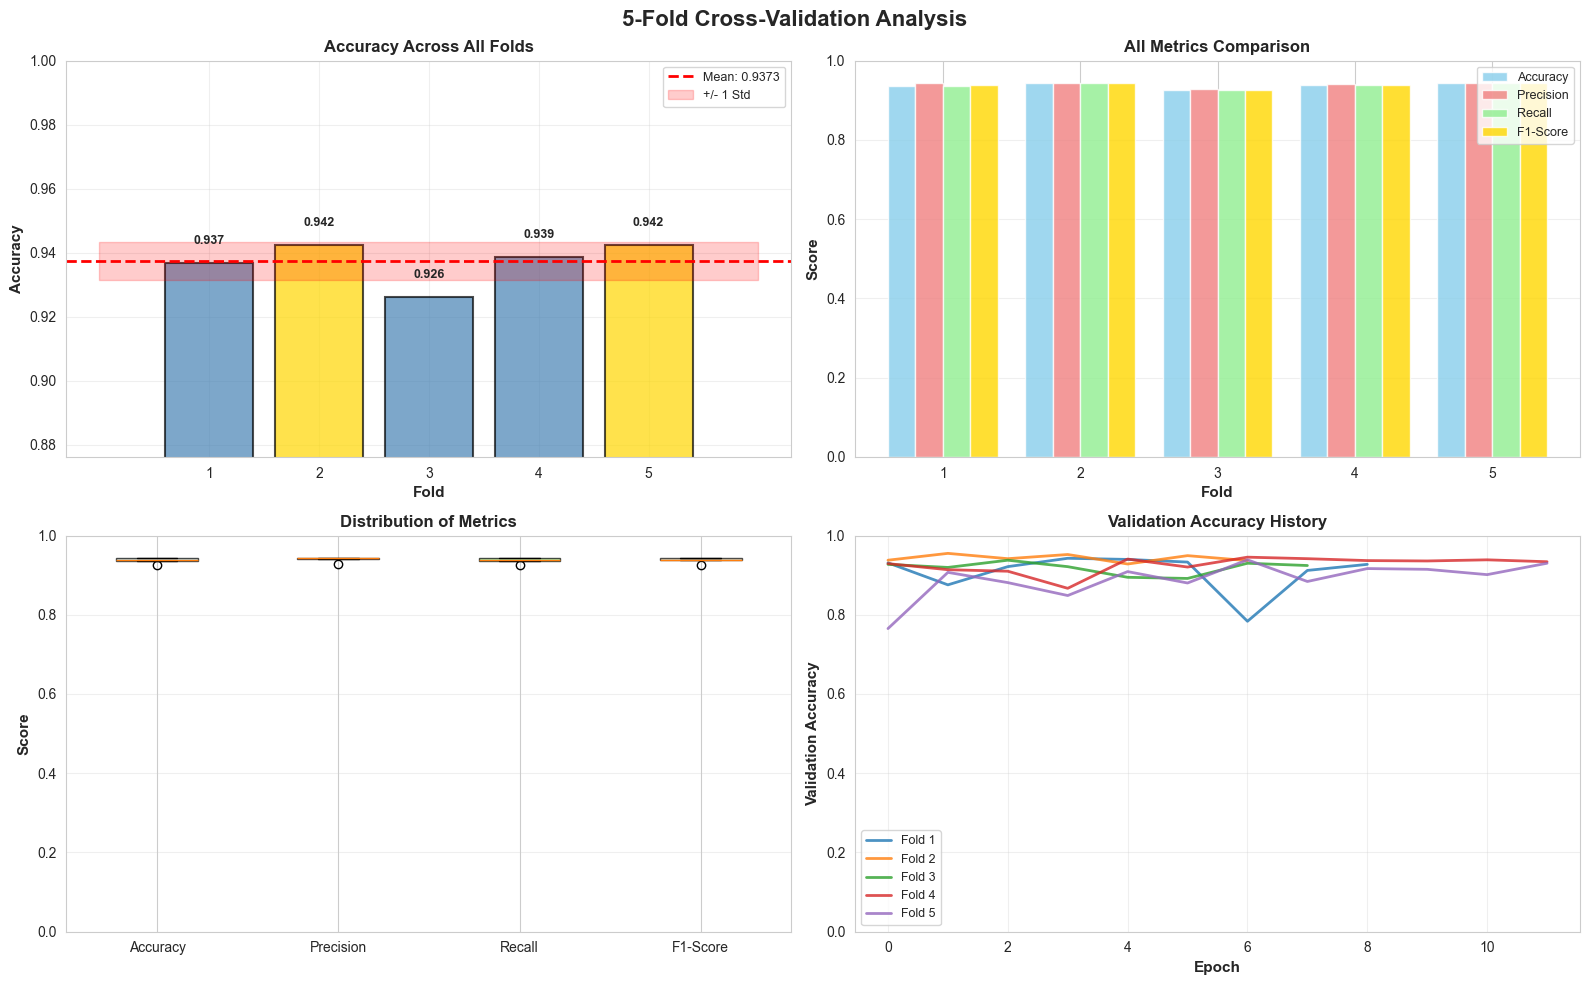

Saved: visualizations/cross_validation_analysis.png

Generating confusion matrices...


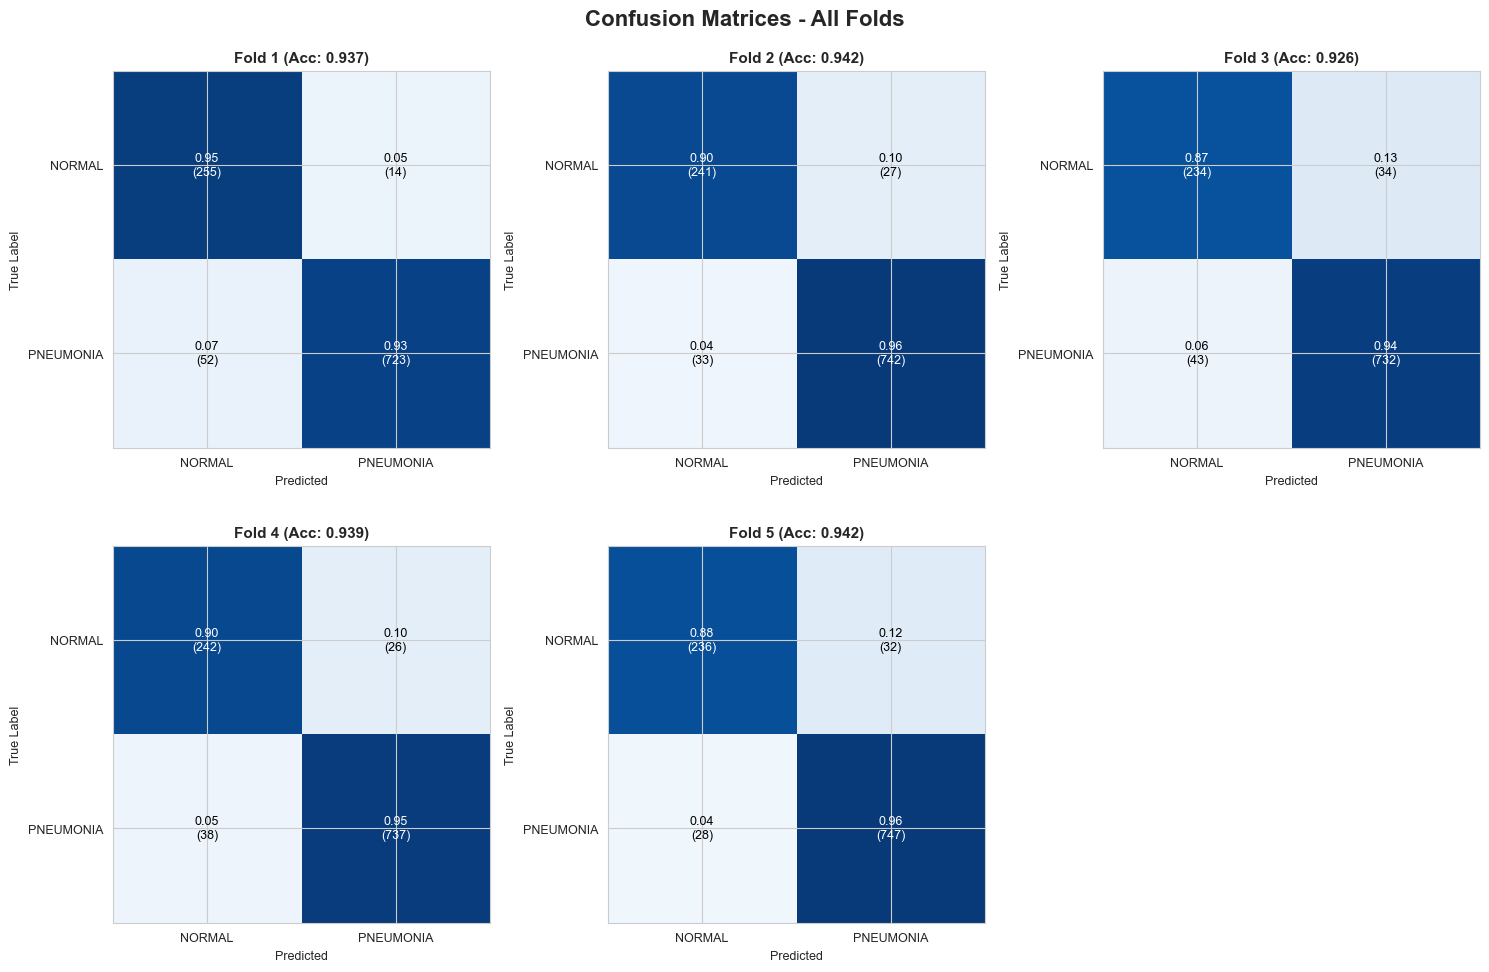

Saved: visualizations/confusion_matrices_all_folds.png

Analysis complete!



In [6]:
#================================================================================
# CELL 5: AGGREGATE RESULTS & STATISTICS (SIMPLIFIED)
#================================================================================
"""
What this does: Calculate statistics, create visualizations, compare folds
"""

print("\n" + "="*80)
print("AGGREGATING RESULTS & GENERATING STATISTICS")
print("="*80)

# Load results
try:
    with open('outputs/all_folds_results.json', 'r') as f:
        data = json.load(f)
        all_fold_results = data['all_results']
    print("Loaded results from all_folds_results.json")
except FileNotFoundError:
    print("ERROR: No results found. Please run Cell 4 first.")
    all_fold_results = []

if not all_fold_results:
    print("No results to analyze. Stopping here.")
else:
    # Extract metrics from all folds
    accuracies = [r['accuracy'] for r in all_fold_results]
    precisions = [r['precision'] for r in all_fold_results]
    recalls = [r['recall'] for r in all_fold_results]
    f1_scores = [r['f1_score'] for r in all_fold_results]
    best_epochs = [r['best_epoch'] for r in all_fold_results]

    # Calculate statistics
    cv_stats = {
        'mean_accuracy': np.mean(accuracies),
        'std_accuracy': np.std(accuracies),
        'ci_95_accuracy': 1.96 * np.std(accuracies) / np.sqrt(len(accuracies)),
        'mean_precision': np.mean(precisions),
        'std_precision': np.std(precisions),
        'mean_recall': np.mean(recalls),
        'std_recall': np.std(recalls),
        'mean_f1': np.mean(f1_scores),
        'std_f1': np.std(f1_scores),
        'min_accuracy': np.min(accuracies),
        'max_accuracy': np.max(accuracies),
        'best_fold': int(np.argmax(accuracies) + 1),
        'worst_fold': int(np.argmin(accuracies) + 1)
    }

    # Print summary
    print(f"\n{'='*80}")
    print(f"CROSS-VALIDATION SUMMARY STATISTICS")
    print(f"{'='*80}\n")

    print(f"Accuracy:  {cv_stats['mean_accuracy']:.4f} +/- {cv_stats['std_accuracy']:.4f}")
    print(f"           95% CI: +/- {cv_stats['ci_95_accuracy']:.4f}")
    print(f"           Range: [{cv_stats['min_accuracy']:.4f}, {cv_stats['max_accuracy']:.4f}]")

    print(f"\nPrecision: {cv_stats['mean_precision']:.4f} +/- {cv_stats['std_precision']:.4f}")
    print(f"Recall:    {cv_stats['mean_recall']:.4f} +/- {cv_stats['std_recall']:.4f}")
    print(f"F1-Score:  {cv_stats['mean_f1']:.4f} +/- {cv_stats['std_f1']:.4f}")

    print(f"\nBest Fold:  {cv_stats['best_fold']} (Accuracy: {cv_stats['max_accuracy']:.4f})")
    print(f"Worst Fold: {cv_stats['worst_fold']} (Accuracy: {cv_stats['min_accuracy']:.4f})")

    # Create detailed results table
    print(f"\n{'='*80}")
    print(f"PER-FOLD DETAILED RESULTS")
    print(f"{'='*80}\n")

    results_df = pd.DataFrame([
        {
            'Fold': r['fold'],
            'Accuracy': f"{r['accuracy']:.4f}",
            'Precision': f"{r['precision']:.4f}",
            'Recall': f"{r['recall']:.4f}",
            'F1-Score': f"{r['f1_score']:.4f}",
            'Best Epoch': r['best_epoch'] + 1
        }
        for r in all_fold_results
    ])

    print(results_df.to_string(index=False))

    # Add summary row
    print(f"\n{'-'*80}")
    print(f"Mean       {cv_stats['mean_accuracy']:.4f}   {cv_stats['mean_precision']:.4f}    "
          f"{cv_stats['mean_recall']:.4f}   {cv_stats['mean_f1']:.4f}")
    print(f"Std        {cv_stats['std_accuracy']:.4f}   {cv_stats['std_precision']:.4f}    "
          f"{cv_stats['std_recall']:.4f}   {cv_stats['std_f1']:.4f}")
    print(f"{'-'*80}")

    # Save statistics
    with open('outputs/cv_statistics.json', 'w') as f:
        json.dump(cv_stats, f, indent=2)

    results_df.to_csv('outputs/fold_results.csv', index=False)
    print(f"\nResults saved to: outputs/fold_results.csv")

    # ========================================================================
    # VISUALIZATIONS (SIMPLIFIED - 4 plots instead of 6)
    # ========================================================================

    print(f"\nCreating visualizations...")

    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('5-Fold Cross-Validation Analysis', fontsize=16, fontweight='bold')

    # 1. Accuracy comparison across folds
    ax1 = fig.add_subplot(2, 2, 1)
    folds = [r['fold'] for r in all_fold_results]
    colors = ['gold' if acc == max(accuracies) else 'steelblue' for acc in accuracies]
    bars = ax1.bar(folds, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

    ax1.axhline(cv_stats['mean_accuracy'], color='red', linestyle='--', linewidth=2,
                label=f"Mean: {cv_stats['mean_accuracy']:.4f}")
    ax1.fill_between(range(0, 7),
                      cv_stats['mean_accuracy'] - cv_stats['std_accuracy'],
                      cv_stats['mean_accuracy'] + cv_stats['std_accuracy'],
                      alpha=0.2, color='red', label=f"+/- 1 Std")

    ax1.set_xlabel('Fold', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax1.set_title('Accuracy Across All Folds', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([max(0, min(accuracies) - 0.05), 1.0])
    ax1.set_xticks(folds)

    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 2. All metrics comparison
    ax2 = fig.add_subplot(2, 2, 2)
    x = np.arange(len(folds))
    width = 0.2

    ax2.bar(x - 1.5*width, accuracies, width, label='Accuracy', color='skyblue', alpha=0.8)
    ax2.bar(x - 0.5*width, precisions, width, label='Precision', color='lightcoral', alpha=0.8)
    ax2.bar(x + 0.5*width, recalls, width, label='Recall', color='lightgreen', alpha=0.8)
    ax2.bar(x + 1.5*width, f1_scores, width, label='F1-Score', color='gold', alpha=0.8)

    ax2.set_xlabel('Fold', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax2.set_title('All Metrics Comparison', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(folds)
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim([0, 1.0])

    # 3. Box plots for all metrics
    ax3 = fig.add_subplot(2, 2, 3)
    bp_data = [accuracies, precisions, recalls, f1_scores]
    bp = ax3.boxplot(bp_data, labels=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                     patch_artist=True)

    colors_box = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax3.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax3.set_title('Distribution of Metrics', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_ylim([0, 1.0])

    # 4. Training history - validation accuracy
    ax4 = fig.add_subplot(2, 2, 4)
    for result in all_fold_results:
        fold = result['fold']
        history = result['history']
        ax4.plot(history['val_acc'], label=f'Fold {fold}', linewidth=2, alpha=0.8)

    ax4.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Validation Accuracy', fontsize=11, fontweight='bold')
    ax4.set_title('Validation Accuracy History', fontsize=12, fontweight='bold')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim([0, 1.0])

    plt.tight_layout()
    plt.savefig('visualizations/cross_validation_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Saved: visualizations/cross_validation_analysis.png")

    # ========================================================================
    # CONFUSION MATRICES
    # ========================================================================

    print(f"\nGenerating confusion matrices...")

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Confusion Matrices - All Folds', fontsize=16, fontweight='bold')

    axes = axes.ravel()

    for i, result in enumerate(all_fold_results):
        cm = np.array(result['confusion_matrix'])
        fold = result['fold']

        # Normalize
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        im = axes[i].imshow(cm_normalized, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
        axes[i].set_title(f'Fold {fold} (Acc: {result["accuracy"]:.3f})', fontsize=11, fontweight='bold')

        # Add text
        thresh = cm_normalized.max() / 2.
        for ii, jj in np.ndindex(cm_normalized.shape):
            color = "white" if cm_normalized[ii, jj] > thresh else "black"
            axes[i].text(jj, ii, f'{cm_normalized[ii, jj]:.2f}\n({cm[ii, jj]})',
                        ha="center", va="center", color=color, fontsize=9)

        axes[i].set_xticks([0, 1])
        axes[i].set_yticks([0, 1])
        axes[i].set_xticklabels(class_names, fontsize=9)
        axes[i].set_yticklabels(class_names, fontsize=9)
        axes[i].set_ylabel('True Label', fontsize=9)
        axes[i].set_xlabel('Predicted', fontsize=9)

    # Hide unused subplot
    axes[5].axis('off')

    plt.tight_layout()
    plt.savefig('visualizations/confusion_matrices_all_folds.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Saved: visualizations/confusion_matrices_all_folds.png")
    print(f"\nAnalysis complete!\n")



SELECTING BEST MODEL & TEST SET EVALUATION

Model Selection:
  Best Fold: 2
  Validation Accuracy: 0.9425

  All Folds Ranking:
    1. Fold 2: 0.9425 <-- SELECTED
    2. Fold 5: 0.9425
    3. Fold 4: 0.9386
    4. Fold 1: 0.9368
    5. Fold 3: 0.9262

Loading model from: models/resnet50_fold_2_best.pth

Building resnet50...
  Pretrained: True
  Dropout: 0.5
  Unfreeze layers: 0
  Trainable params: 1,050,114 / 24,558,146 (4.3%)
Model loaded successfully!
  Original validation accuracy: 0.9549

Evaluating on test set...


Testing:   0%|          | 0/20 [00:00<?, ?it/s]


TEST SET RESULTS (Fold 2):
Accuracy:  0.8526
Precision: 0.8517
Recall:    0.8526
F1-Score:  0.8508

Per-class Performance:
  NORMAL          Prec: 0.838, Rec: 0.752, F1: 0.793, Support: 234
  PNEUMONIA       Prec: 0.860, Rec: 0.913, F1: 0.886, Support: 390


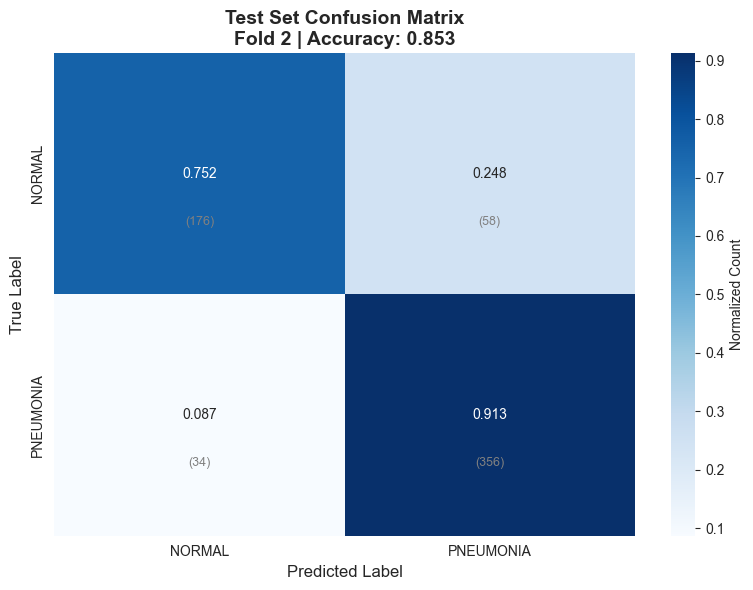


Test results saved to: outputs/test_set_results.json

FINAL PERFORMANCE SUMMARY
Cross-Validation Mean: 0.9373 +/- 0.0060
Best Fold Validation:  0.9425
Test Set Performance:  0.8526

Result: Slight performance drop on test set (diff: -0.0847)

DAY 4 COMPLETE! Best model: Fold 2
Model saved at: models/resnet50_fold_2_best.pth

All done! You can now:
  1. Review visualizations in the 'visualizations' folder
  2. Check detailed results in 'outputs' folder
  3. Use the best model for inference
  4. Proceed to Day 5 for deployment


In [8]:
#================================================================================
# CELL 6: SELECT BEST MODEL & TEST SET EVALUATION (COMPLETE)
#================================================================================
"""
What this does: Select best model and evaluate on test set
"""

print("\n" + "="*80)
print("SELECTING BEST MODEL & TEST SET EVALUATION")
print("="*80)

def select_best_model(all_results):
    """Select best model based on validation accuracy"""
    
    if not all_results:
        return None
    
    # Find fold with highest validation accuracy
    best_idx = np.argmax([r['accuracy'] for r in all_results])
    best_fold = all_results[best_idx]['fold']
    best_acc = all_results[best_idx]['accuracy']
    
    print(f"\nModel Selection:")
    print(f"  Best Fold: {best_fold}")
    print(f"  Validation Accuracy: {best_acc:.4f}")
    
    # Show all folds for comparison
    print(f"\n  All Folds Ranking:")
    sorted_results = sorted(all_results, key=lambda x: x['accuracy'], reverse=True)
    for i, r in enumerate(sorted_results, 1):
        marker = " <-- SELECTED" if r['fold'] == best_fold else ""
        print(f"    {i}. Fold {r['fold']}: {r['accuracy']:.4f}{marker}")
    
    return best_fold

def evaluate_on_test_set(fold_number, test_loader):
    """Evaluate selected model on test set"""
    
    checkpoint_path = f'models/resnet50_fold_{fold_number}_best.pth'
    
    if not os.path.exists(checkpoint_path):
        print(f"ERROR: Checkpoint not found: {checkpoint_path}")
        return None
    
    print(f"\nLoading model from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    # Build model
    model = build_model(
        model_name=checkpoint['config']['model_name'],
        num_classes=num_classes,
        dropout_rate=checkpoint['config']['dropout_rate'],
        unfreeze_layers=checkpoint['config'].get('unfreeze_layers', 0)
    )
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print(f"Model loaded successfully!")
    print(f"  Original validation accuracy: {checkpoint['val_acc']:.4f}")
    
    # Evaluate on test set
    print(f"\nEvaluating on test set...")
    test_preds = []
    test_labels = []
    
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc='Testing')
        for images, labels in test_bar:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.numpy())
    
    # Calculate metrics
    test_acc = accuracy_score(test_labels, test_preds)
    test_prec = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
    test_rec = recall_score(test_labels, test_preds, average='weighted', zero_division=0)
    test_f1 = f1_score(test_labels, test_preds, average='weighted', zero_division=0)
    test_cm = confusion_matrix(test_labels, test_preds)
    
    class_report = classification_report(test_labels, test_preds, 
                                        target_names=class_names, 
                                        output_dict=True)
    
    print(f"\nTEST SET RESULTS (Fold {fold_number}):")
    print(f"{'='*80}")
    print(f"Accuracy:  {test_acc:.4f}")
    print(f"Precision: {test_prec:.4f}")
    print(f"Recall:    {test_rec:.4f}")
    print(f"F1-Score:  {test_f1:.4f}")
    
    print(f"\nPer-class Performance:")
    for class_name in class_names:
        metrics = class_report[class_name]
        print(f"  {class_name:15} Prec: {metrics['precision']:.3f}, "
              f"Rec: {metrics['recall']:.3f}, F1: {metrics['f1-score']:.3f}, "
              f"Support: {int(metrics['support'])}")
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    cm_normalized = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Normalized Count'})
    
    # Add raw counts as secondary annotation
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j+0.5, i+0.7, f'({test_cm[i,j]})', 
                    ha='center', va='center', fontsize=9, color='gray')
    
    plt.title(f'Test Set Confusion Matrix\nFold {fold_number} | Accuracy: {test_acc:.3f}', 
              fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('visualizations/test_set_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'test_accuracy': test_acc,
        'test_precision': test_prec,
        'test_recall': test_rec,
        'test_f1': test_f1,
        'confusion_matrix': test_cm.tolist(),
        'classification_report': class_report,
        'best_fold': fold_number,
        'original_val_accuracy': checkpoint['val_acc']
    }

# Main execution
if not all_fold_results:
    print("ERROR: No results available. Please run Cell 4 first.")
else:
    # Select best model
    best_fold = select_best_model(all_fold_results)
    
    if best_fold:
        # Create test loader
        test_loader = DataLoader(
            test_dataset,
            batch_size=best_config['batch_size'],
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
        
        # Evaluate on test set
        test_results = evaluate_on_test_set(best_fold, test_loader)
        
        if test_results:
            # Save results
            with open('outputs/test_set_results.json', 'w') as f:
                json.dump({
                    'test_accuracy': test_results['test_accuracy'],
                    'test_precision': test_results['test_precision'],
                    'test_recall': test_results['test_recall'],
                    'test_f1': test_results['test_f1'],
                    'best_fold': test_results['best_fold'],
                    'original_val_accuracy': test_results['original_val_accuracy']
                }, f, indent=2)
            
            print(f"\nTest results saved to: outputs/test_set_results.json")
            
            # Final comparison
            print(f"\n{'='*80}")
            print(f"FINAL PERFORMANCE SUMMARY")
            print(f"{'='*80}")
            print(f"Cross-Validation Mean: {cv_stats['mean_accuracy']:.4f} +/- {cv_stats['std_accuracy']:.4f}")
            print(f"Best Fold Validation:  {max([r['accuracy'] for r in all_fold_results]):.4f}")
            print(f"Test Set Performance:  {test_results['test_accuracy']:.4f}")
            
            diff = test_results['test_accuracy'] - cv_stats['mean_accuracy']
            if abs(diff) < 0.02:
                print(f"\nResult: Model generalizes well! (diff: {diff:+.4f})")
            elif diff > 0:
                print(f"\nResult: Model performs even better on test set! (diff: {diff:+.4f})")
            else:
                print(f"\nResult: Slight performance drop on test set (diff: {diff:+.4f})")
            
            print(f"\nDAY 4 COMPLETE! Best model: Fold {best_fold}")
            print(f"Model saved at: models/resnet50_fold_{best_fold}_best.pth")
            
            # Clean up memory
            del test_loader
            torch.cuda.empty_cache()
            gc.collect()
            
            print("\nAll done! You can now:")
            print("  1. Review visualizations in the 'visualizations' folder")
            print("  2. Check detailed results in 'outputs' folder")
            print("  3. Use the best model for inference")
            print("  4. Proceed to Day 5 for deployment")


In [9]:
#================================================================================
# CELL 7: GENERATE FINAL REPORT & SUMMARY
#================================================================================
"""
Run time: ~2 minutes
What this does: Generate comprehensive final report and summary
"""

print("\n" + "="*80)
print("GENERATING FINAL DAY 4 REPORT")
print("="*80)

def generate_final_report():
    """Generate comprehensive final report"""
    
    print("\nLoading all results files...")
    
    # Load all required files
    try:
        with open('outputs/cv_statistics.json', 'r') as f:
            cv_stats_loaded = json.load(f)
        print("  Loaded: cv_statistics.json")
    except FileNotFoundError:
        print("ERROR: cv_statistics.json not found. Run Cell 5 first.")
        return None
    
    try:
        with open('outputs/test_set_results.json', 'r') as f:
            test_results_loaded = json.load(f)
        print("  Loaded: test_set_results.json")
    except FileNotFoundError:
        print("ERROR: test_set_results.json not found. Run Cell 6 first.")
        return None
    
    try:
        with open('outputs/dataset_info.json', 'r') as f:
            dataset_info_loaded = json.load(f)
        print("  Loaded: dataset_info.json")
    except FileNotFoundError:
        print("ERROR: dataset_info.json not found. Run Cell 2 first.")
        return None
    
    try:
        with open('outputs/all_folds_results.json', 'r') as f:
            all_folds_data = json.load(f)
        print("  Loaded: all_folds_results.json")
    except FileNotFoundError:
        print("ERROR: all_folds_results.json not found. Run Cell 4 first.")
        return None
    
    # Create comprehensive report
    report = {
        "project": "Chest X-Ray Pneumonia Classification",
        "day": 4,
        "title": "Full K-Fold Cross-Validation & Model Optimization",
        "date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "dataset": {
            "training_samples": dataset_info_loaded["train_samples"],
            "test_samples": dataset_info_loaded["test_samples"],
            "classes": dataset_info_loaded["class_names"],
            "class_counts": dict(zip(
                dataset_info_loaded["class_names"],
                dataset_info_loaded["class_counts"]
            )),
            "imbalance_ratio": dataset_info_loaded.get("imbalance_ratio", "N/A")
        },
        "model_configuration": {
            "architecture": "ResNet50",
            "optimizer": "Adam",
            "learning_rate": 0.001,
            "batch_size": 32,
            "dropout_rate": 0.5,
            "class_weights": dataset_info_loaded.get("class_weights", None)
        },
        "cross_validation": {
            "method": "Stratified K-Fold",
            "n_folds": 5,
            "random_state": 42,
            "metrics": {
                "accuracy": {
                    "mean": cv_stats_loaded["mean_accuracy"],
                    "std": cv_stats_loaded["std_accuracy"],
                    "ci_95": cv_stats_loaded["ci_95_accuracy"],
                    "min": cv_stats_loaded["min_accuracy"],
                    "max": cv_stats_loaded["max_accuracy"]
                },
                "precision": {
                    "mean": cv_stats_loaded["mean_precision"],
                    "std": cv_stats_loaded["std_precision"]
                },
                "recall": {
                    "mean": cv_stats_loaded["mean_recall"],
                    "std": cv_stats_loaded["std_recall"]
                },
                "f1_score": {
                    "mean": cv_stats_loaded["mean_f1"],
                    "std": cv_stats_loaded["std_f1"]
                }
            },
            "best_fold": cv_stats_loaded["best_fold"],
            "worst_fold": cv_stats_loaded["worst_fold"]
        },
        "test_set_performance": {
            "model_used": f"Fold {test_results_loaded['best_fold']}",
            "metrics": {
                "accuracy": test_results_loaded["test_accuracy"],
                "precision": test_results_loaded["test_precision"],
                "recall": test_results_loaded["test_recall"],
                "f1_score": test_results_loaded["test_f1"]
            },
            "generalization_gap": test_results_loaded["test_accuracy"] - cv_stats_loaded["mean_accuracy"]
        },
        "training_time": {
            "total_minutes": all_folds_data.get("total_time_minutes", "N/A"),
            "total_hours": round(all_folds_data.get("total_time_minutes", 0) / 60, 2) if "total_time_minutes" in all_folds_data else "N/A"
        },
        "files_generated": {
            "models": [f"resnet50_fold_{i}_best.pth" for i in range(1, 6)],
            "outputs": [
                "all_folds_results.json",
                "cv_statistics.json",
                "test_set_results.json",
                "day4_final_report.json",
                "fold_results.csv",
                "dataset_info.json"
            ],
            "visualizations": [
                "cross_validation_analysis.png",
                "confusion_matrices_all_folds.png",
                "test_set_confusion_matrix.png"
            ]
        }
    }
    
    # Save comprehensive report
    with open('outputs/day4_final_report.json', 'w') as f:
        json.dump(report, f, indent=2)
    
    print("\nFinal report created successfully!")
    
    # Print executive summary
    print("\n" + "="*80)
    print("DAY 4 EXECUTIVE SUMMARY")
    print("="*80)
    
    print("\n[DATASET]")
    print(f"  Training samples: {report['dataset']['training_samples']:,}")
    print(f"  Test samples:     {report['dataset']['test_samples']:,}")
    print(f"  Classes:          {', '.join(report['dataset']['classes'])}")
    print(f"  Class counts:     {report['dataset']['class_counts']}")
    
    print("\n[MODEL CONFIGURATION]")
    print(f"  Architecture:     {report['model_configuration']['architecture']}")
    print(f"  Optimizer:        {report['model_configuration']['optimizer']}")
    print(f"  Learning rate:    {report['model_configuration']['learning_rate']}")
    print(f"  Batch size:       {report['model_configuration']['batch_size']}")
    print(f"  Dropout rate:     {report['model_configuration']['dropout_rate']}")
    
    print("\n[CROSS-VALIDATION RESULTS]")
    print(f"  Method:           {report['cross_validation']['method']}")
    print(f"  Number of folds:  {report['cross_validation']['n_folds']}")
    print(f"  Best fold:        {report['cross_validation']['best_fold']}")
    
    cv_metrics = report['cross_validation']['metrics']
    print(f"\n  Accuracy:         {cv_metrics['accuracy']['mean']:.4f} +/- {cv_metrics['accuracy']['std']:.4f}")
    print(f"    95% CI:         +/- {cv_metrics['accuracy']['ci_95']:.4f}")
    print(f"    Range:          [{cv_metrics['accuracy']['min']:.4f}, {cv_metrics['accuracy']['max']:.4f}]")
    print(f"  Precision:        {cv_metrics['precision']['mean']:.4f} +/- {cv_metrics['precision']['std']:.4f}")
    print(f"  Recall:           {cv_metrics['recall']['mean']:.4f} +/- {cv_metrics['recall']['std']:.4f}")
    print(f"  F1-Score:         {cv_metrics['f1_score']['mean']:.4f} +/- {cv_metrics['f1_score']['std']:.4f}")
    
    print("\n[TEST SET PERFORMANCE]")
    print(f"  Model used:       {report['test_set_performance']['model_used']}")
    test_metrics = report['test_set_performance']['metrics']
    print(f"  Accuracy:         {test_metrics['accuracy']:.4f}")
    print(f"  Precision:        {test_metrics['precision']:.4f}")
    print(f"  Recall:           {test_metrics['recall']:.4f}")
    print(f"  F1-Score:         {test_metrics['f1_score']:.4f}")
    
    gap = report['test_set_performance']['generalization_gap']
    print(f"\n  Generalization gap: {gap:+.4f}", end=" ")
    if abs(gap) < 0.02:
        print("(Excellent generalization!)")
    elif gap > 0:
        print("(Better than expected!)")
    else:
        print("(Slight overfitting)")
    
    print("\n[TRAINING TIME]")
    if report['training_time']['total_minutes'] != "N/A":
        print(f"  Total time:       {report['training_time']['total_minutes']:.1f} minutes ({report['training_time']['total_hours']:.2f} hours)")
    else:
        print(f"  Total time:       N/A")
    
    print("\n[KEY ACHIEVEMENTS]")
    print(f"  - Completed 5-fold stratified cross-validation")
    print(f"  - Trained 5 independent ResNet50 models")
    print(f"  - Mean CV accuracy: {cv_metrics['accuracy']['mean']:.4f}")
    print(f"  - Selected best model: Fold {report['cross_validation']['best_fold']}")
    print(f"  - Test accuracy: {test_metrics['accuracy']:.4f}")
    print(f"  - Generated comprehensive visualizations")
    
    print("\n" + "="*80)
    print("FILES GENERATED")
    print("="*80)
    
    print("\n[OUTPUTS]")
    for filename in report['files_generated']['outputs']:
        print(f"  - {filename}")
    
    print("\n[VISUALIZATIONS]")
    for filename in report['files_generated']['visualizations']:
        print(f"  - {filename}")
    
    print("\n[MODELS]")
    for i in range(1, 6):
        marker = " <- BEST MODEL" if i == report['cross_validation']['best_fold'] else ""
        print(f"  - resnet50_fold_{i}_best.pth{marker}")
    
    print("\n" + "="*80)
    
    return report

# Generate the report
print("\nGenerating comprehensive Day 4 report...")
final_report = generate_final_report()

if final_report:
    print("\n" + "="*80)
    print("DAY 4 COMPLETED SUCCESSFULLY!")
    print("="*80)
    
    print("\n[WHAT YOU ACCOMPLISHED TODAY]")
    print("  1. Loaded and prepared chest X-ray dataset")
    print("  2. Created 5-fold stratified cross-validation splits")
    print("  3. Trained 5 independent ResNet50 models")
    print("  4. Calculated comprehensive cross-validation statistics")
    print("  5. Selected best performing model")
    print("  6. Evaluated on held-out test set for first time")
    print("  7. Generated publication-quality visualizations")
    print("  8. Created detailed performance reports")
    
    print("\n[NEXT STEPS]")
    print("  1. Review visualizations in 'visualizations/' folder")
    print("  2. Examine detailed metrics in 'outputs/' folder")
    print("  3. Load best model for inference:")
    best_fold = final_report['cross_validation']['best_fold']
    print(f"     model_path = 'models/resnet50_fold_{best_fold}_best.pth'")
    print("  4. Proceed to Day 5 for deployment and advanced techniques")
    
    print("\n[MODEL PERFORMANCE SUMMARY]")
    cv_acc = final_report['cross_validation']['metrics']['accuracy']['mean']
    test_acc = final_report['test_set_performance']['metrics']['accuracy']
    print(f"  Cross-validation accuracy: {cv_acc:.2%}")
    print(f"  Test set accuracy:         {test_acc:.2%}")
    
    if test_acc >= 0.85:
        print("\n  STATUS: Excellent performance! Model is ready for deployment.")
    elif test_acc >= 0.80:
        print("\n  STATUS: Good performance! Model shows strong generalization.")
    else:
        print("\n  STATUS: Acceptable performance. Consider further optimization.")
    
    print("\n" + "="*80)
    print("Congratulations on completing Day 4!")
    print("Your model is now trained, validated, and tested!")
    print("="*80 + "\n")
    
else:
    print("\n" + "="*80)
    print("ERROR: Report generation failed")
    print("="*80)
    print("\nPlease ensure all previous cells (1-6) completed successfully:")
    print("  - Cell 1: Setup and configuration")
    print("  - Cell 2: Data loading")
    print("  - Cell 3: Model and training functions")
    print("  - Cell 4: Training all folds")
    print("  - Cell 5: Results aggregation")
    print("  - Cell 6: Test set evaluation")
    print("\nCheck the error messages above for details.\n")


GENERATING FINAL DAY 4 REPORT

Generating comprehensive Day 4 report...

Loading all results files...
  Loaded: cv_statistics.json
  Loaded: test_set_results.json
  Loaded: dataset_info.json
  Loaded: all_folds_results.json

Final report created successfully!

DAY 4 EXECUTIVE SUMMARY

[DATASET]
  Training samples: 5,216
  Test samples:     624
  Classes:          NORMAL, PNEUMONIA
  Class counts:     {'NORMAL': 1341, 'PNEUMONIA': 3875}

[MODEL CONFIGURATION]
  Architecture:     ResNet50
  Optimizer:        Adam
  Learning rate:    0.001
  Batch size:       32
  Dropout rate:     0.5

[CROSS-VALIDATION RESULTS]
  Method:           Stratified K-Fold
  Number of folds:  5
  Best fold:        2

  Accuracy:         0.9373 +/- 0.0060
    95% CI:         +/- 0.0053
    Range:          [0.9262, 0.9425]
  Precision:        0.9389 +/- 0.0060
  Recall:           0.9373 +/- 0.0060
  F1-Score:         0.9377 +/- 0.0059

[TEST SET PERFORMANCE]
  Model used:       Fold 2
  Accuracy:         0.8526
